<a href="https://colab.research.google.com/github/Aldrin-Fanir/Carvana-UNet/blob/main/Carvana_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Required Library

In [1]:
import copy
import os
import random
import zipfile
from math import atan2, cos, sin, sqrt, pi, log

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
from numpy import linalg as LA
from torch import optim, nn
from torch.utils.data import DataLoader, random_split
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from tqdm import tqdm

# Double Convolution

In [2]:
class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.conv_op = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding = 1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),\
        nn.ReLU(inplace=True)
    )

  def forward(self, x):
    return self.conv_op(x)

# Downsampling

In [3]:
class DownSample(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.conv = DoubleConv(in_channels, out_channels)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

  def forward(self, x):
    down = self.conv(x)
    p = self.pool(down)

    return down, p

# Upsampling

In [4]:
class UpSample(nn.Module):
  def __init__(self, in_channels, out_channels):
    super().__init__()
    self.up = nn.ConvTranspose2d(in_channels, in_channels//2, kernel_size=2, stride=2)
    self.conv = DoubleConv(in_channels, out_channels)

  def forward(self, x1, x2):
    x1 = self.up(x1)
    x = torch.cat([x1, x2], 1)

    return self.conv(x)

# UNet Architecture

In [5]:
class UNet(nn.Module):
  def __init__(self, in_channels, num_classes):
    super().__init__()

    self.down_convolution_1 = DownSample(in_channels, 64)
    self.down_convolution_2 = DownSample(64, 128)
    self.down_convolution_3 = DownSample(128, 256)
    self.down_convolution_4 = DownSample(256, 512)

    self.bottle_neck = DoubleConv(512, 1024)

    self.up_convolution_1 = UpSample(1024, 512)
    self.up_convolution_2 = UpSample(512, 256)
    self.up_convolution_3 = UpSample(256, 128)
    self.up_convolution_4 = UpSample(128, 64)

    self.output = nn.Conv2d(64, out_channels = num_classes, kernel_size=1)


  def forward(self, x):
    down_1, p1 = self.down_convolution_1(x)
    down_2, p2 = self.down_convolution_2(p1)
    down_3, p3 = self.down_convolution_3(p2)
    down_4, p4 = self.down_convolution_4(p3)

    b = self.bottle_neck(p4)

    up_1 = self.up_convolution_1(b, down_4)
    up_2 = self.up_convolution_2(up_1, down_3)
    up_3 = self.up_convolution_3(up_2, down_2)
    up_4 = self.up_convolution_4(up_3, down_1)

    out = self.output(up_4)

    return out


# Test Model with dummy object

In [6]:
input_image = torch.rand((1, 3, 512, 512))
model = UNet(3, 1)
output = model(input_image)
print(output.size())

torch.Size([1, 1, 512, 512])


# Loading the Carvana Dataset

# Drive Mount : Import Google Drive

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Directory of Images and Masks

In [8]:
root_path = '/content/drive/MyDrive/UNet/data'

In [9]:
print("Is path correct?", os.path.exists(root_path))

Is path correct? True


# Carvana Dataset

In [10]:
class CarvanaDataset(Dataset):
  def __init__(self, root_path, limit = None):
    self.root_path = root_path
    self.limit = limit

    self.images = sorted([root_path + "/train/" + i for i in os.listdir(root_path + "/train")]) [:self.limit]
    self.masks = sorted([root_path + "/train_masks/" + i for i in os.listdir(root_path + "/train_masks")]) [:self.limit]

    self.transform = transforms.Compose([
        transforms.Resize((512, 512)),
        transforms.ToTensor()
    ])

    if self.limit is None:
      self.limit = len(self.images)


  def __getitem__(self, index):
    img = Image.open(self.images[index]).convert("RGB")
    mask = Image.open(self.masks[index]).convert("L")

    return self.transform(img), self.transform(mask)


  def __len__(self):
    return min(len(self.images), self.limit)

# Is Dataset load Properly!!

Batch 1:
Images shape: torch.Size([1, 3, 512, 512])
Masks shape: torch.Size([1, 1, 512, 512])


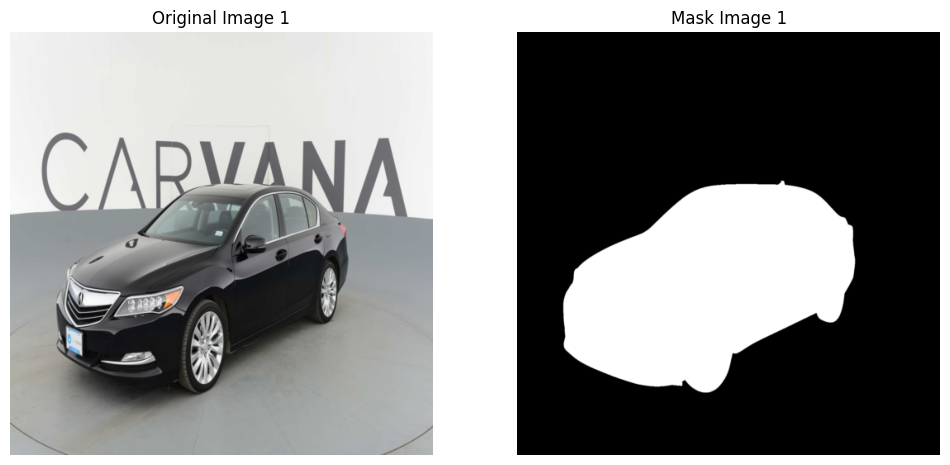

Batch 2:
Images shape: torch.Size([1, 3, 512, 512])
Masks shape: torch.Size([1, 1, 512, 512])


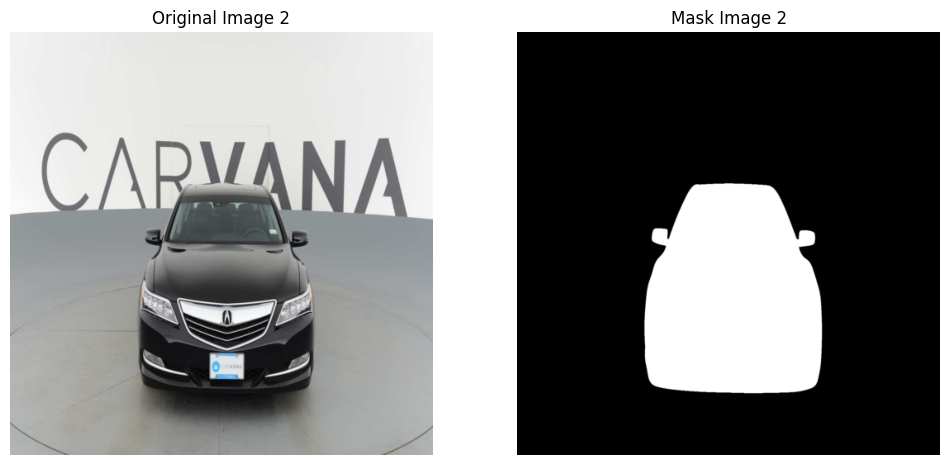

Batch 3:
Images shape: torch.Size([1, 3, 512, 512])
Masks shape: torch.Size([1, 1, 512, 512])


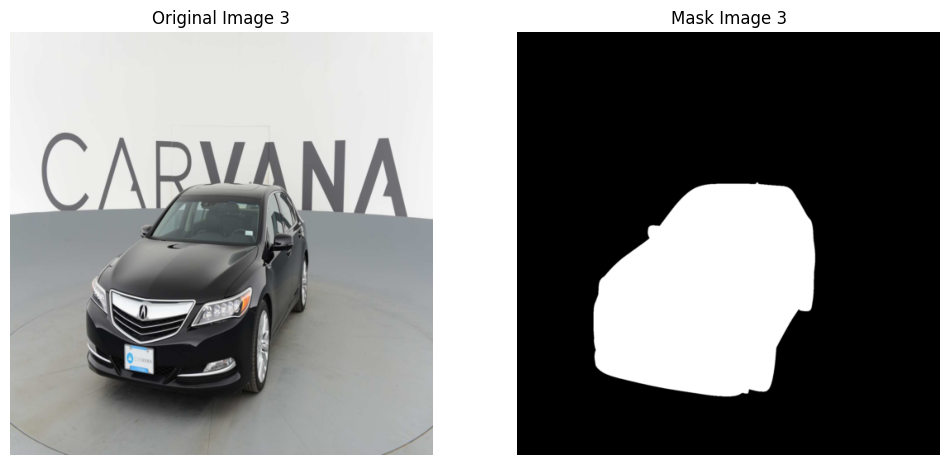

In [11]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Dataset instance
dataset = CarvanaDataset(root_path, limit=3)

# DataLoader instance
loader = DataLoader(dataset, batch_size=1, shuffle=True)


for i, (images, masks) in enumerate(loader):
    print(f"Batch {i+1}:")
    print(f"Images shape: {images.shape}")
    print(f"Masks shape: {masks.shape}")
    plt.figure(figsize=(12,6))

    #Train Image
    plt.subplot(1, 2, 1)
    plt.imshow(images[0].permute(1, 2, 0).cpu().numpy())
    plt.title(f'Original Image {i+1}')
    plt.axis('off')

    # Mask Image
    plt.subplot(1, 2, 2)
    plt.imshow(masks[0].squeeze(0).cpu().numpy(), cmap='gray')
    plt.title(f'Mask Image {i+1}')
    plt.axis('off')

    plt.show()



# Trainning the Model!!

In [12]:
train_dataset = CarvanaDataset(root_path)
generator = torch.Generator().manual_seed(25)

In [13]:
train_dataset, test_dataset = random_split(train_dataset, [0.8, 0.2], generator = generator)

In [14]:
test_dataset, val_dataset = random_split(test_dataset, [0.5,0.5], generator = generator)

**Running this experiment with CUDA**

In [15]:
num_workers = 1
device = "cuda" if torch.cuda.is_available() else "cpu"

if device == "cuda":
  num_workers = torch.cuda.device_count()*4

**Now We setup our model using the AdamW optimizer and the BCEWithLogitsLoss**

In [16]:
Learning_rate = 3e-4
batch_size = 8 # Reduced batch size to prevent OutOfMemoryError

train_dataloader = DataLoader(dataset = train_dataset, num_workers = num_workers, pin_memory = False, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(dataset = test_dataset, num_workers = num_workers, pin_memory = False, batch_size = batch_size, shuffle = False)
val_dataloader = DataLoader(dataset = val_dataset, num_workers = num_workers, pin_memory = False, batch_size = batch_size, shuffle = False)

# Initialize the UNet with num_classes=1 for binary segmentation and move it to the device
model = UNet(in_channels = 3, num_classes = 1).to(device)
optimizer = optim.AdamW(model.parameters(), lr = Learning_rate)
criterion = nn.BCEWithLogitsLoss()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


**Evaluating Segmentation Performance with DICEMetric**

In [17]:
def dice_coefficient(prediction, target, epsilon=1e-07):
  prediction_copy = prediction.clone()

  prediction_copy[prediction_copy<0] = 0
  prediction_copy[prediction_copy>0] = 1

  intersection = abs(torch.sum(prediction_copy * target))
  union = abs(torch.sum(prediction_copy) + torch.sum(target))
  dice = (2.0 * intersection + epsilon) / (union + epsilon)

  return dice

In [18]:
torch.cuda.empty_cache()

**Training**

In [19]:
epochs = 10

train_losses = []
train_dcs = []

val_losses = []
val_dcs = []

for epoch in tqdm(range(epochs)):
  model.train()
  train_running_loss = 0
  train_running_dc = 0

  for idx, img_mask in enumerate(tqdm(train_dataloader, position=0, leave = True)):
    img = img_mask[0].float().to(device)
    mask = img_mask[1].float().to(device)

    y_pred = model(img)
    optimizer.zero_grad()

    dc = dice_coefficient(y_pred, mask)
    loss = criterion(y_pred, mask)

    train_running_loss += loss.item()
    train_running_dc += dc.item()

    loss.backward()
    optimizer.step()



  train_loss = train_running_loss / (idx + 1)
  train_dc = train_running_dc / (idx + 1)

  train_losses.append(train_loss)
  train_dcs.append(train_dc)


  model.eval()
  val_running_loss = 0
  val_running_dc = 0

  with torch.no_grad():
    for idx, img_mask in enumerate(tqdm(val_dataloader, position=0, leave = True)):
      img = img_mask[0].float().to(device)
      mask = img_mask[1].float().to(device)

      y_pred = model(img)
      loss = criterion(y_pred , mask)
      dc = dice_coefficient(y_pred, mask)

      val_running_loss += loss.item()
      val_running_dc += dc.item()

    val_loss = val_running_loss / (idx + 1)
    val_dc = val_running_dc / (idx + 1)

  val_losses.append(val_loss)
  val_dcs.append(val_dc)


  print("-" * 30)
  print(f"Training Loss EPOCH {epoch + 1}: {train_loss:.4f}")
  print(f"Training DICE EPOCH {epoch + 1}: {train_dc:.4f}")
  print("\n")
  print(f"Validation Loss EPOCH {epoch + 1}: {val_loss:.4f}")
  print(f"Validation DICE EPOCH {epoch + 1}: {val_dc:.4f}")
  print("-" * 30)



#Saving the model
torch.save(model.state_dict(), 'Carvana_UNet_Model.pth')

 10%|█         | 1/10 [19:28<2:55:12, 1168.00s/it]

------------------------------
Training Loss EPOCH 1: 0.1575
Training DICE EPOCH 1: 0.8255


Validation Loss EPOCH 1: 0.0452
Validation DICE EPOCH 1: 0.9577
------------------------------


 20%|██        | 2/10 [34:10<2:13:18, 999.78s/it] 

------------------------------
Training Loss EPOCH 2: 0.0476
Training DICE EPOCH 2: 0.9560


Validation Loss EPOCH 2: 0.0276
Validation DICE EPOCH 2: 0.9738
------------------------------


 30%|███       | 3/10 [48:58<1:50:41, 948.83s/it]

------------------------------
Training Loss EPOCH 3: 0.0216
Training DICE EPOCH 3: 0.9801


Validation Loss EPOCH 3: 0.0172
Validation DICE EPOCH 3: 0.9840
------------------------------


 40%|████      | 4/10 [1:03:38<1:32:11, 921.84s/it]

------------------------------
Training Loss EPOCH 4: 0.1525
Training DICE EPOCH 4: 0.8474


Validation Loss EPOCH 4: 0.0679
Validation DICE EPOCH 4: 0.9330
------------------------------


 50%|█████     | 5/10 [1:18:22<1:15:40, 908.14s/it]

------------------------------
Training Loss EPOCH 5: 0.0427
Training DICE EPOCH 5: 0.9603


Validation Loss EPOCH 5: 0.0241
Validation DICE EPOCH 5: 0.9774
------------------------------


 60%|██████    | 6/10 [1:33:07<1:00:01, 900.29s/it]

------------------------------
Training Loss EPOCH 6: 0.0209
Training DICE EPOCH 6: 0.9807


Validation Loss EPOCH 6: 0.0178
Validation DICE EPOCH 6: 0.9833
------------------------------


 70%|███████   | 7/10 [1:47:53<44:46, 895.59s/it]  

------------------------------
Training Loss EPOCH 7: 0.0156
Training DICE EPOCH 7: 0.9856


Validation Loss EPOCH 7: 0.0143
Validation DICE EPOCH 7: 0.9867
------------------------------


 80%|████████  | 8/10 [2:02:34<29:41, 890.95s/it]

------------------------------
Training Loss EPOCH 8: 0.0410
Training DICE EPOCH 8: 0.9568


Validation Loss EPOCH 8: 0.0159
Validation DICE EPOCH 8: 0.9854
------------------------------


 90%|█████████ | 9/10 [2:17:15<14:47, 887.87s/it]

------------------------------
Training Loss EPOCH 9: 0.0160
Training DICE EPOCH 9: 0.9854


Validation Loss EPOCH 9: 0.0140
Validation DICE EPOCH 9: 0.9867
------------------------------


100%|██████████| 10/10 [2:31:58<00:00, 911.89s/it]


------------------------------
Training Loss EPOCH 10: 0.0115
Training DICE EPOCH 10: 0.9893


Validation Loss EPOCH 10: 0.0110
Validation DICE EPOCH 10: 0.9898
------------------------------
